In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
import pandas as pd


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='2F4K.protein.pdb'
trajectory='2F4K.protein.s10.dcd'
xray_CA_pdb='2f4K.xray.CA.pdb'
outdir='output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: output
pdb: 2F4K.protein.pdb
trjaectory: 2F4K.protein.s10.dcd


In [3]:
stride_sel=1
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 62791

Starting frame: 0

Last frame: 62791

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [178]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


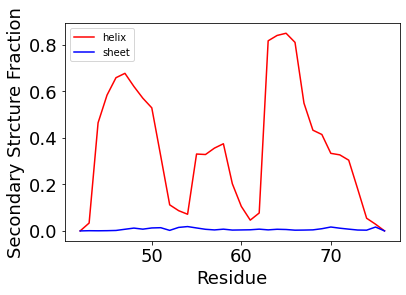

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




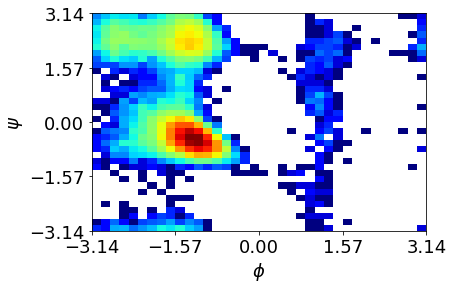

In [12]:
plot_phipsi(45)


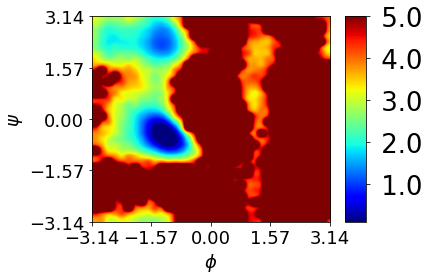

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

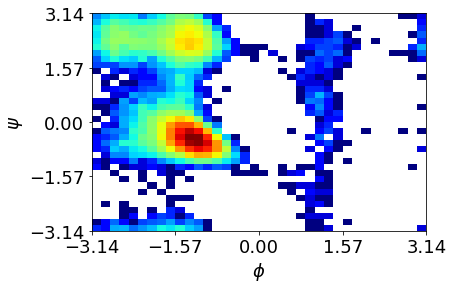

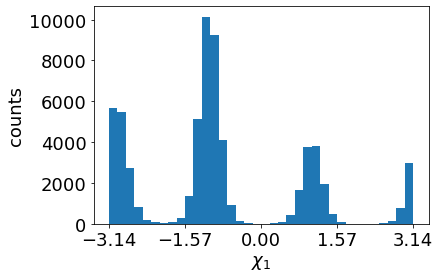

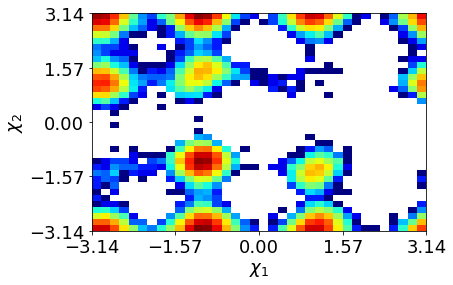

In [14]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [15]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [16]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 62791 frames, 35 atoms, 35 residues, and unitcells at 0x7fc6c098ad50>

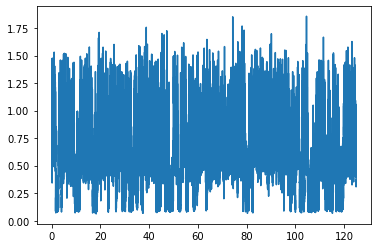

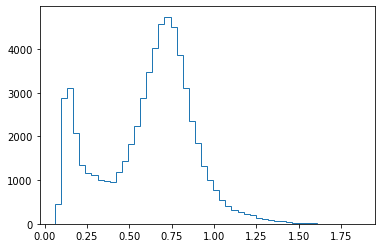

In [17]:
CA_trj_sel=trj.topology.select("name CA")
CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [18]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)


10163

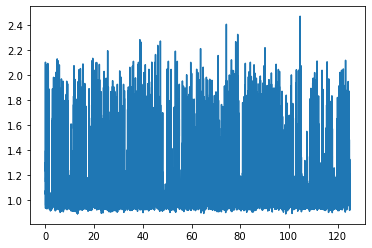

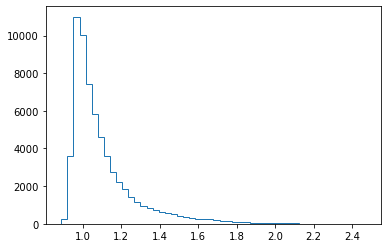

In [19]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [20]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(62791, 2)


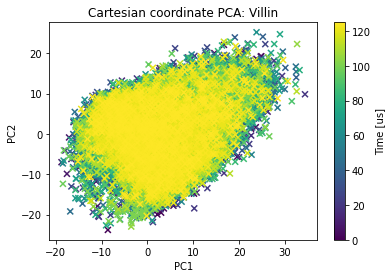

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

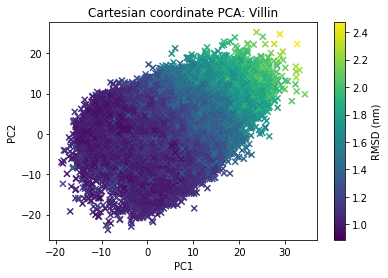

In [22]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

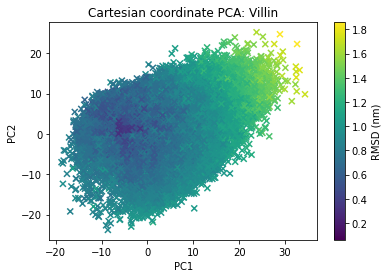

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

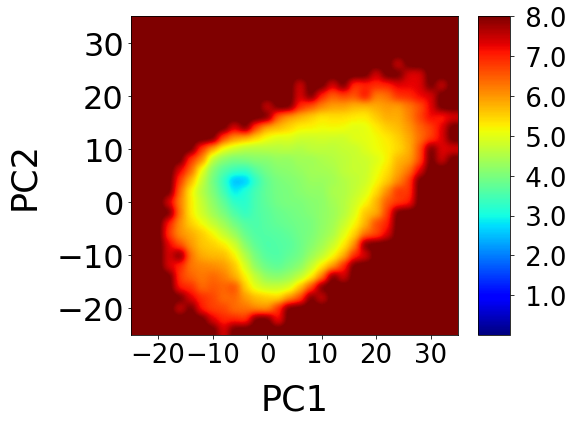

In [24]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


(-1.0, 4.0)

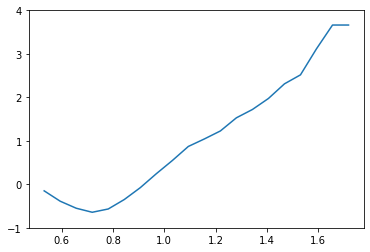

In [25]:
#Lets Plot Free Energies as a function of RMSD and Rg
def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

dG_RMSD, xedges=free_energy1D(rmsd,300,0.5,1.75,20)
plt.plot(xedges,dG_RMSD)
plt.ylim(-1,4)

In [26]:
#Visualize the free energy basin
basin_frames=np.where((rmsd>0.6) & (rmsd<0.8)) [0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+"basin.dcd")

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

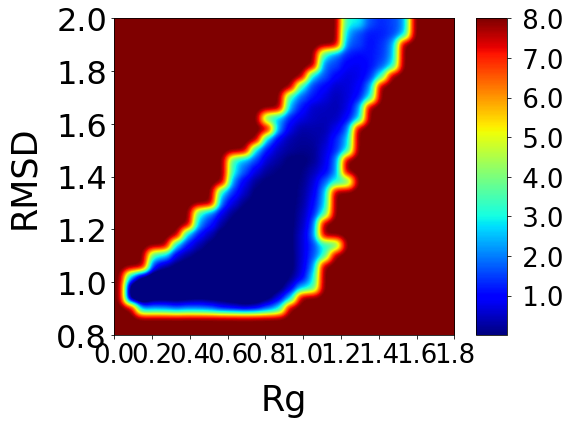

In [27]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [28]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [29]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

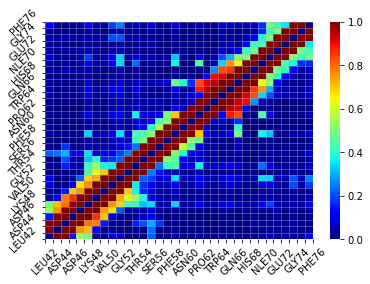

In [30]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [31]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [32]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [33]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

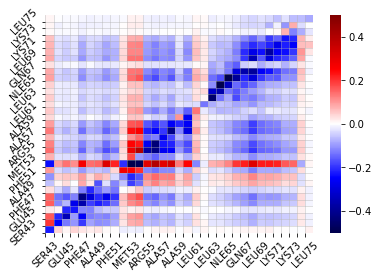

In [34]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

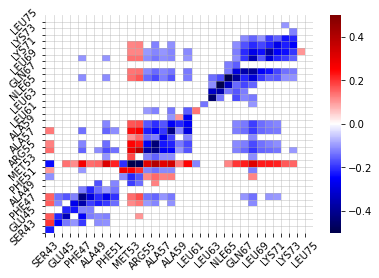

In [35]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

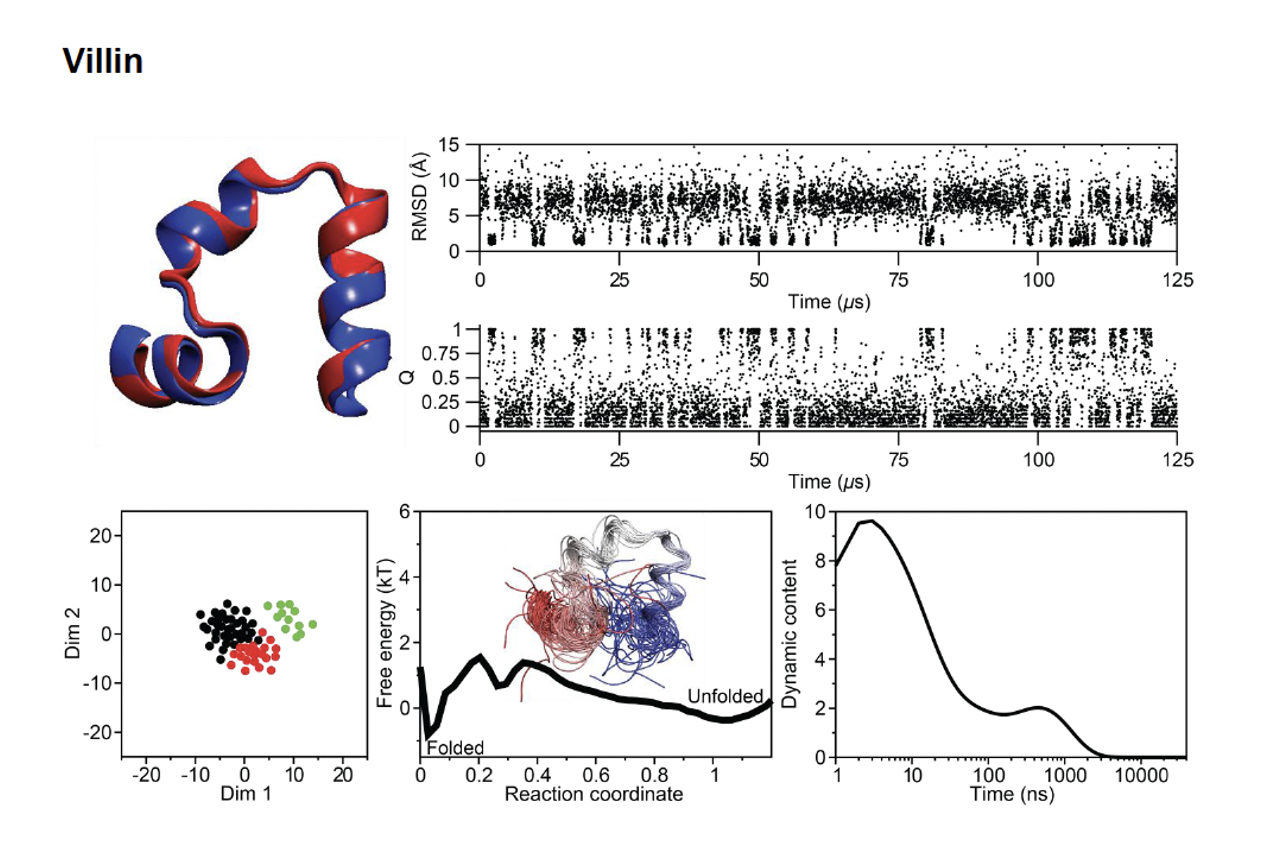

First we need to determine the native contacts and calculate Q

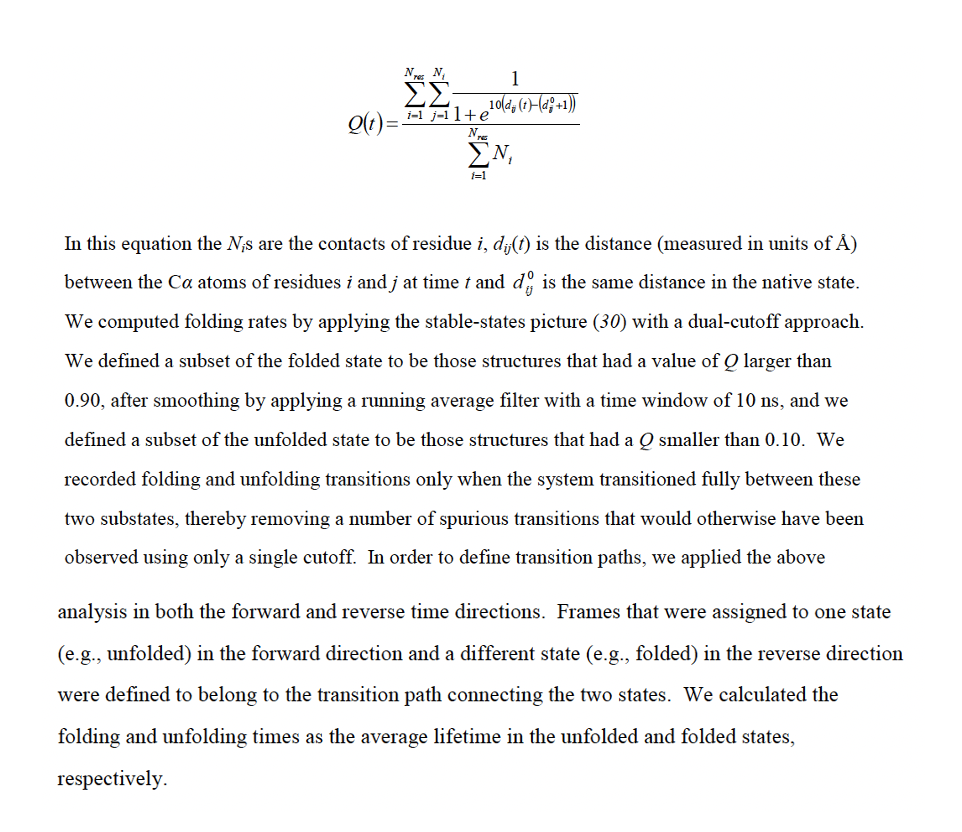

In [36]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x7fc6c08c4810>

In [37]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D=[]
index=[]
#QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residuyes
for i in range(0, 35):
    for j in range(0, 35):
     if(abs(i-j)>7):
        dist = md.compute_distances(xray_CA, [[i, j]])[0]
        native_distance_matrix1D.append(dist[0])
        index.append([i,j])

np.shape(native_distance_matrix1D)
#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10
index=np.asarray(index)



In [38]:
np.shape(native_distance_matrix1D)

(756,)

In [39]:
#Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory
traj_CA_distance_matrix1D=[]

for i in range(0, 35):
    for j in range(0, 35):
     if(abs(i-j)>7):
        dist = md.compute_distances(trjCA, [[i, j]])[:,0]
        traj_CA_distance_matrix1D.append(dist)

np.shape(native_distance_matrix1D)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

    


In [40]:
np.shape(native_distance_matrix1D)


(756,)

In [41]:
np.shape(traj_CA_distance_matrix1D)

(756, 62791)

In [42]:
#Make Sure that For each Distance you can compare that native distance to the trajectory distance 
for i in range(0,756):
    print(native_distance_matrix1D[i],traj_CA_distance_matrix1D[i])

9.288557 [16.155031 16.38443  15.260145 ... 10.365486  9.400145 12.631355]
11.002597 [14.991053  18.914196  16.925203  ... 12.177633  10.576793  13.6923685]
13.174997 [12.063679 19.837738 15.076105 ... 14.053832 12.601304 15.135903]
12.974674 [11.490325 20.77126  11.941987 ... 12.761735 11.892329 13.68544 ]
11.456033 [ 8.780671 17.22652  11.801032 ... 10.801501 10.204086 11.492741]
9.985726 [11.540491 16.265432 11.015314 ...  9.802754  9.483252  9.529006]
11.460043 [14.431149 17.379915 13.927379 ... 12.928819 12.819076 12.805997]
14.596794 [16.64362  18.88648  14.560976 ... 15.174979 14.900313 14.800943]
13.557264 [19.898039 18.924843 18.07636  ... 14.240339 13.832406 13.058009]
11.562319 [18.631268 16.311272 17.276617 ... 16.864334 16.301714 15.83342 ]
13.011403 [18.036263 19.347965 14.816498 ... 15.967855 16.244146 15.269197]
16.130928 [21.76416  21.978966 17.618877 ... 13.227169 13.359386 12.541676]
17.153845 [22.86161  21.04869  17.059034 ... 15.995742 16.364857 14.958039]
16.86790

In [43]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Xray_Distance_Expand=np.zeros(np.shape(traj_CA_distance_matrix1D))
for i in range(0,len(traj_CA_distance_matrix1D)):
    Xray_Distance_Expand[i,:]=native_distance_matrix1D[i]
    
np.shape(Xray_Distance_Expand)

(756, 62791)

In [44]:
Xray_Distance_Expand

array([[ 9.28855705,  9.28855705,  9.28855705, ...,  9.28855705,
         9.28855705,  9.28855705],
       [11.00259686, 11.00259686, 11.00259686, ..., 11.00259686,
        11.00259686, 11.00259686],
       [13.17499733, 13.17499733, 13.17499733, ..., 13.17499733,
        13.17499733, 13.17499733],
       ...,
       [10.74501801, 10.74501801, 10.74501801, ..., 10.74501801,
        10.74501801, 10.74501801],
       [ 9.27620125,  9.27620125,  9.27620125, ...,  9.27620125,
         9.27620125,  9.27620125],
       [11.34115219, 11.34115219, 11.34115219, ..., 11.34115219,
        11.34115219, 11.34115219]])

In [45]:
#Write a function to Calculate Q 
def getQ(distCA,distXray):
    diff=10*np.subtract(distCA,distXray+1)
    expvalue=np.exp(diff)
    up=1/(1+expvalue)
    return np.sum(up,axis=0)/len(distCA)

Qlist=getQ(traj_CA_distance_matrix1D,Xray_Distance_Expand)

In [46]:
np.shape(Qlist)

(62791,)

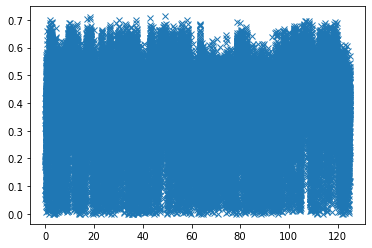

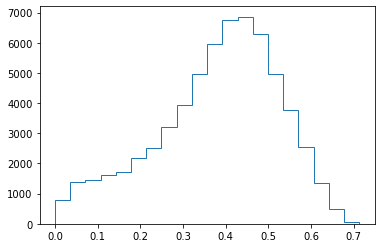

In [47]:
#Plot Q and a Histogram
plt.plot(time,Qlist, marker='x',linewidth=.01)
plt.show()
plt.clf()

plt.hist(Qlist,histtype='step',bins=20)
plt.show()

In [48]:
Qlist

array([0.20385502, 0.05239883, 0.35247471, ..., 0.41889783, 0.34997046,
       0.47709844])

In [49]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q


In [50]:

native_average=np.average(traj_CA_distance_matrix1D[:,native_frames],axis=1)
np.shape(native_average)

(756,)

In [51]:
Native_Contact_Indices=np.where(native_average<10.0)[0]
len(Native_Contact_Indices)

46

In [52]:
Native_Contacts_Trj_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
np.shape(Native_Contacts_Trj_Dist)

Native_Contacts_Xray_Dist=Xray_Distance_Expand[Native_Contact_Indices]

In [53]:
#np.shape(Native_Contacts_Trj_Dist)
np.shape(Native_Contacts_Xray_Dist)

(46, 62791)

In [54]:
#Check that we're comparing all the correct distances 
for i in range(0,46):
    print(Native_Contacts_Xray_Dist[i,0],Native_Contacts_Trj_Dist[i])

9.985726356506348 [11.540491 16.265432 11.015314 ...  9.802754  9.483252  9.529006]
10.452459335327148 [ 9.374432  16.245033  11.174518  ...  8.4822445  8.2288065  8.788097 ]
9.704253196716309 [11.477718  15.051355  11.518175  ...  7.9602337  8.147505   7.693935 ]
9.603489875793457 [ 9.620813  16.892593   9.833138  ...  7.9195204  7.720853   7.720747 ]
7.096728324890137 [ 8.358078  14.116966   8.165926  ...  4.8814363  4.800289   5.1262226]
7.0852813720703125 [10.051856  12.382599   8.767696  ...  5.715454   6.071064   5.3546863]
9.99271011352539 [13.804028  13.989109  12.2466545 ...  8.040899   8.667675   8.60963  ]
9.574566841125488 [12.595353 18.082281  6.733689 ...  9.501221  8.676781  9.204168]
8.3038969039917 [11.918608  15.588733   6.0125976 ...  7.458983   7.0765905  7.861574 ]
9.653462409973145 [13.711605 14.434618  6.118204 ...  9.374109  9.527126  8.898192]
9.633481979370117 [12.349012 15.095367  7.886838 ...  8.530871  8.416407  8.578752]
10.225194931030273 [14.985344 14.85

In [55]:

Qlist_native=getQ(Native_Contacts_Trj_Dist,Native_Contacts_Xray_Dist)

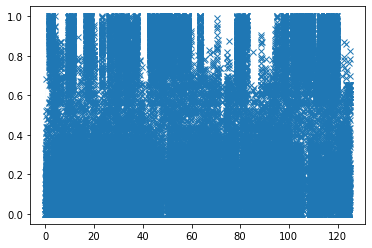

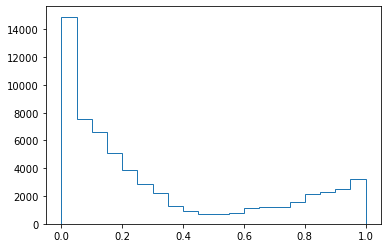

In [56]:
#Plot Q using only our native frames
plt.plot(time,Qlist_native, marker='x',linewidth=.01)
plt.show()
plt.clf()

plt.hist(Qlist_native,histtype='step',bins=20)
plt.show()

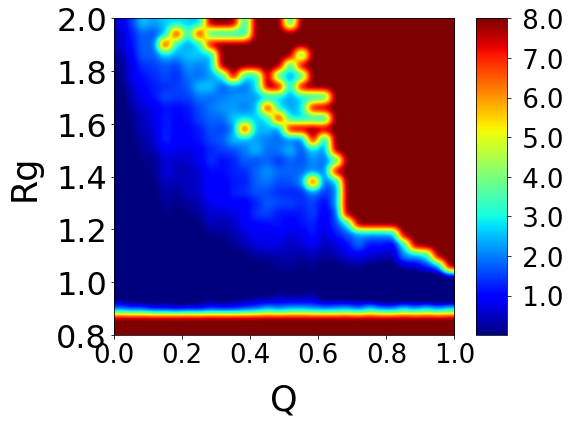

In [57]:
#2.) Plot some 2D free energy surfaces (Q vs. Rg) (Advanced: Plot Q vs. Fraction Helix)

dG,xedges,yedges=free_energy(rg, Qlist_native, 300, 0.8, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8)
plt.yticks(size='26')
plt.tight_layout()

In [58]:
#3.) Use the dual cut-off approach with Q to identify transition paths.  This means from the distribution of Q you decide on a threshold for folded and unfolded states, you assign a transition between to states as every event where you start beneath one threshold and your cross over the second threshold.


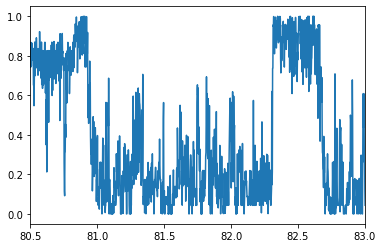

<Figure size 432x288 with 0 Axes>

In [59]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 
plt.plot(time,Qlist_native)
plt.xlim(80.5,83)
plt.show()
plt.clf()

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


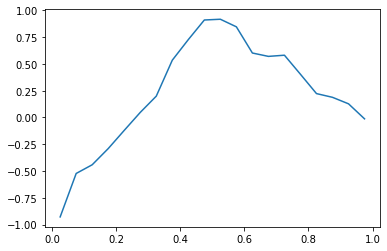

In [60]:
#1D free energy 

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

dG_RMSD, xedges=free_energy1D(Qlist_native,300,0,1,20)
plt.plot(xedges,dG_RMSD)

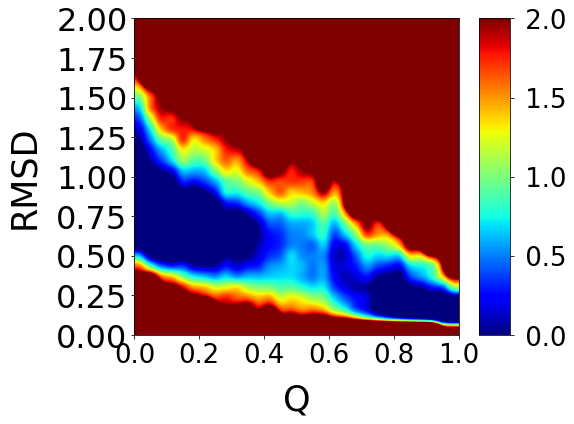

In [61]:

dG,xedges,yedges=free_energy(rmsd, Qlist_native, 300, 0, 2, 0, 1)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 0.5,1,1.5,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.0, vmax=2)
plt.yticks(size='26')
plt.tight_layout()

In [62]:
#4.) Here is a trick to identify transition paths: 1) Assign frames to Folded or Unfolded states using the dual cut-off approach going from time 0 - 125us.  2) Reverse the array of Q values (so it goes reverse from 125us to 0 us).  3) Assign frames to folded or unfolded states uses the reversed array.  4) Reverse the direction of the assignments from step (3), so it now has assignments from states going from 0 to 125 us.  4) Everywhere the two areas don't match is a transition path (edited) 



In [63]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations
df = pd.DataFrame(Qlist_native)
Qwindow=df.rolling(window=5).mean()
np.shape(Qwindow)

(62791, 1)

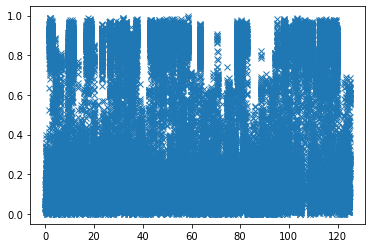

<Figure size 432x288 with 0 Axes>

In [64]:
plt.plot(time,Qwindow, marker='x',linewidth=.01)
plt.show()
plt.clf()

In [65]:
Qforward_window=np.asarray(Qwindow)

In [115]:
for i in range(4,10):
    print(i)

4
5
6
7
8
9


In [116]:
Qforward_window[:10]

array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [0.17127293],
       [0.13586871],
       [0.15189111],
       [0.08491161],
       [0.06699735],
       [0.03340698]])

In [118]:
def assign(Qassign,pre):
    foldlist=[pre,pre,pre,pre]
    for i in range(4,62791):
        if pre==0:
            if Qassign[i]>0.9:
                pre=1
                foldlist.append(1)
            else:
                foldlist.append(0)
            continue
        if pre==1:
            if Qassign[i]<0.1:
                pre=0
                foldlist.append(0)
            else:
                foldlist.append(1)
            continue
    return foldlist

In [119]:
assignforward=assign(Qforward_window,0)

In [120]:
Qreverse=np.flip(Qlist_native)
dfreverse = pd.DataFrame(Qreverse)
Qreversewindow=dfreverse.rolling(window=5).mean()

In [121]:
Qreverse_window=np.asarray(Qreversewindow)

In [122]:
assignreverse=assign(Qreverse_window,0)

In [123]:
Qassign=(np.asarray(assignforward+np.flip(assignreverse)))/2

In [124]:
len(trj)

62791

In [126]:
len(Qassign)

62791

In [127]:
transition_frames=trj[np.where((Qassign>0.4) & (Qassign < 0.6))[0]]
unfold_frames=trj[np.where(Qforward_window < 0.1)[0]]
fold_frames=trj[np.where(Qreverse_window > 0.9)[0]]

In [128]:
len(transition_frames)
len(unfold_frames)
len(fold_frames)

4491

In [129]:
#5) Calculate Contact Maps, Dihedral Correlations, and secondary structure propensities for A) The unfolded States B) Transition Paths C) The folded states

In [130]:
transition_frames[1]

<mdtraj.Trajectory with 1 frames, 577 atoms, 70 residues, and unitcells at 0x7fc6a5967a10>

In [131]:
trj[1]

<mdtraj.Trajectory with 1 frames, 577 atoms, 70 residues, and unitcells at 0x7fc6c0b23290>

In [147]:
#Lets Make a Contact Map
def get_contact_map(frames):
    contact_maps = []
    contact_distances = []

    for i in range(0, 34):
        contact_map = []
        contact_distance = []
        for j in range(0, 34):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(frames, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                distance = np.average(array)
                contact_distance.append(distance)
                contact = np.where(array < 0.5, 1, 0)
                contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        contact_distances.append(contact_distance)
    return np.asarray(contact_maps).astype(float)


In [148]:
transition_contact_map=get_contact_map(transition_frames)
unfold_contact_map=get_contact_map(unfold_frames)
fold_contact_map=get_contact_map(fold_frames)

In [149]:
fold_contact_map

array([[0.        , 1.        , 0.99888666, ..., 0.02872411, 0.03050546,
        0.11044311],
       [1.        , 0.        , 1.        , ..., 0.01759074, 0.00690269,
        0.01536406],
       [0.99888666, 1.        , 0.        , ..., 0.03340013, 0.00712536,
        0.01603206],
       ...,
       [0.02872411, 0.01759074, 0.03340013, ..., 0.        , 1.        ,
        0.99977733],
       [0.03050546, 0.00690269, 0.00712536, ..., 1.        , 0.        ,
        1.        ],
       [0.11044311, 0.01536406, 0.01603206, ..., 0.99977733, 1.        ,
        0.        ]])

In [150]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

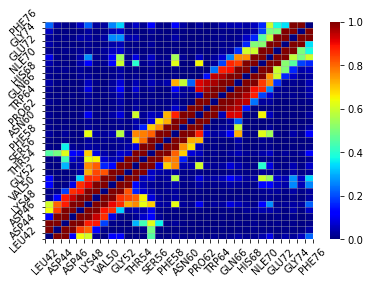

In [151]:
ax = sns.heatmap(transition_contact_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

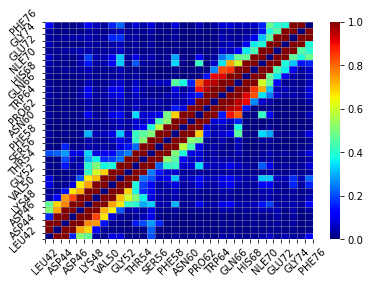

In [152]:
ax = sns.heatmap(fold_contact_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

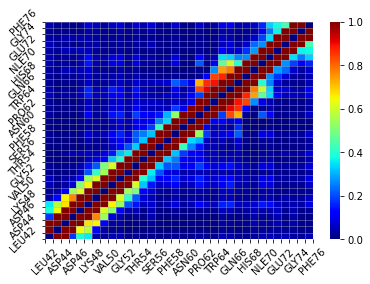

In [153]:
ax = sns.heatmap(unfold_contact_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [155]:
# Make correlation contact map
def get_corr_map(frames):
    
    indices_phi, phis = md.compute_phi(frames)
    indices_psi, psis = md.compute_psi(frames)
    indices_chi1, chi1s = md.compute_chi1(frames)
    indices_chi2, chi2s = md.compute_chi2(frames)
    
    phi_dict={}
    dihedral_dict = { 'phi': { },
              'psi': { }}

    for i in range(0,len(indices_phi)):
      indices=indices_phi[i]
      atom=top.atom(indices[1])
      resnum=top.atom(indices[1]).residue.resSeq
      dihedral_dict['phi'][resnum]=phis[:,i]

    for i in range(0,len(indices_psi)):
      indices=indices_psi[i]
      atom=top.atom(indices[1])
      resnum=top.atom(indices[1]).residue.resSeq
      dihedral_dict['psi'][resnum]=psis[:,i]
    
    correlation_maps = []
    for i in range(43, 76):
        cor_map = []
        for j in range(43, 76):
            phi=dihedral_dict['phi'][i]
            psi=dihedral_dict['psi'][j]
            ccor=circular_corr(psi,phi)
            cor_map.append(ccor)
        correlation_maps.append(cor_map)
    final_cor_map = np.asarray(correlation_maps).astype(float)
    return final_cor_map

In [87]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

In [156]:
transition_cor_map=get_corr_map(transition_frames)
unfold_cor_map=get_corr_map(unfold_frames)
fold_cor_map=get_corr_map(fold_frames)

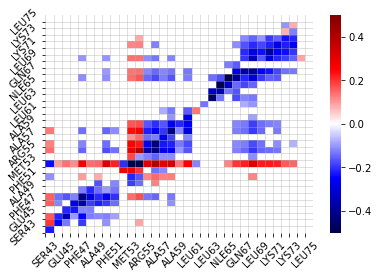

In [160]:
mask = np.zeros_like(fold_cor_map)
zeros=np.where((fold_cor_map<0.10) & (fold_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

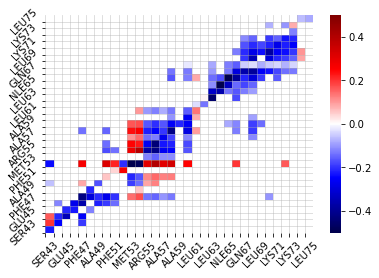

In [162]:
mask = np.zeros_like(transition_cor_map)
zeros=np.where((transition_cor_map<0.10) & (transition_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

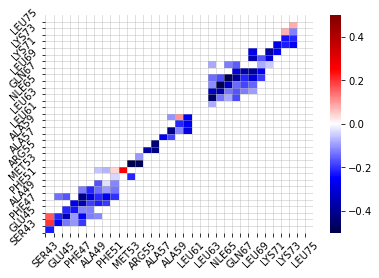

In [161]:
mask = np.zeros_like(unfold_cor_map)
zeros=np.where((unfold_cor_map<0.10) & (unfold_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

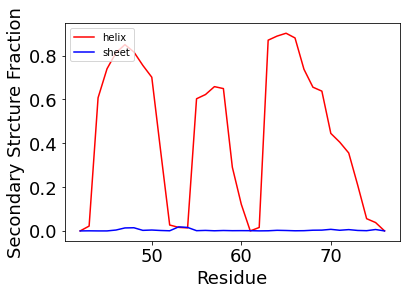

In [179]:
#secondary structure for the transition path
Hprop,Eprop=dssp_convert(dssp[np.where((Qassign>0.4) & (Qassign < 0.6))[0]])
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


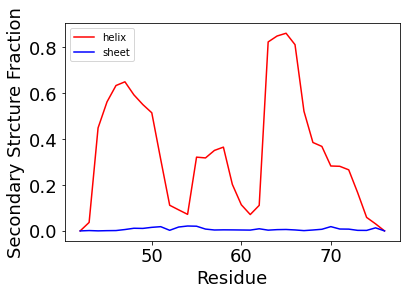

In [180]:
#secondary structure for the fold structure
Hprop,Eprop=dssp_convert(dssp[np.where(Qreverse_window > 0.9)[0]])
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


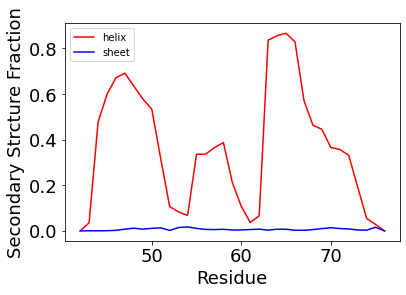

In [181]:
#secondary structure for the unfold structure
Hprop,Eprop=dssp_convert(dssp[np.where(Qreverse_window <0.1)[0]])
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

In [ ]:
#Ask and answer a question about the transition paths, either globally (about the statistical properties of all transition paths - ie. what is the probability of forming a certain set of native contacts in the first 50% of transition paths, what is the average helical propensity in the first and second halves of transition paths)), or locally (what is the sequence of native contact formation and helix formation in some particular transition paths)